In [ ]:
!pip install datasets

# Импортируем нужные библиотеки

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')

# Предобработка

In [4]:
nltk.download('punkt_tab')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


'cuda'

In [5]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [6]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [7]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [8]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

# Бейслайн

In [9]:
class Baseline(nn.Module):
    def __init__(self, hidden_dim, vocab_size, agregation_type, num_layers, p, num_classes : int=4):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.project = nn.Linear(hidden_dim, num_classes)

        self.foa = nn.Tanh()
        self.dropout = nn.Dropout(p=p)
        self.agregation_type = agregation_type

    def forward(self, input_batch):
        embeddings = self.embeddings(input_batch) # [batch_size, seq_len, hidden_size]
        output, _ = self.rnn(embeddings)

        if self.agregation_type == 'max':
            output = output.max(dim=1)[0]

        elif self.agregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError('Invalid agregation type')

        output = self.dropout(self.linear(self.foa(output))) # batch_size, hidden_dim
        predict = self.project(self.foa(output)) # batch_size, num_classes
        return predict


In [10]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

In [11]:
num_epochs = 5
eval_step = len(train_dataloader) // 2

base_loss = {}
base_accuracy = {}

for agregation_type in ['max', 'mean']:
    print(f"starting training with agregation_type: {agregation_type}")
    losses = []
    accuracy = []

    model = Baseline(vocab_size=len(vocab), hidden_dim=256, agregation_type=agregation_type, num_layers=1, p=0.1).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epochs):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch : {epoch}')):
            optimizer.zero_grad()

            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            if i % eval_step == 0:
                model.eval()
                accuracy.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))
    base_loss[agregation_type] = losses
    base_accuracy[agregation_type] = accuracy




starting training with agregation_type: max


Training epoch : 0:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch : 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch : 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch : 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch : 4:   0%|          | 0/3750 [00:00<?, ?it/s]

starting training with agregation_type: mean


Training epoch : 0:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch : 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch : 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch : 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch : 4:   0%|          | 0/3750 [00:00<?, ?it/s]

In [16]:
[base_accuracy[key][-1]  for key in base_accuracy.keys()]

[0.9055999517440796, 0.9021999835968018]

Зафиксируем лучший скор - max pooling с 0.90559

Посмотрим на графики на бейслайне

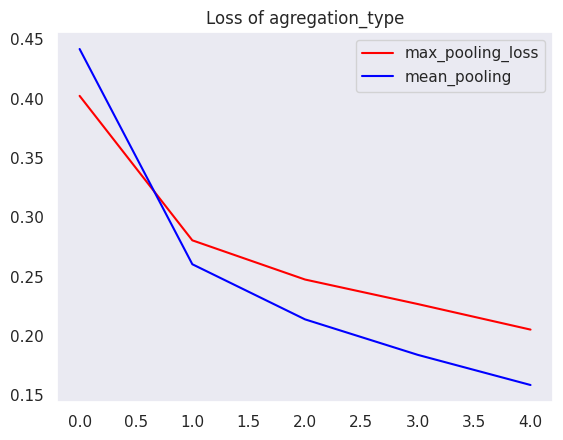

In [17]:
import matplotlib.pyplot as plt

x_max = np.arange(len(base_loss['max']))
x_mean = np.arange(len(base_loss['mean']))

plt.plot(x_max, base_loss['max'], label='max_pooling_loss', color='red')

plt.plot(x_mean, base_loss['mean'], label='mean_pooling', color='blue')

plt.grid()

plt.title('Loss of agregation_type')
plt.legend()

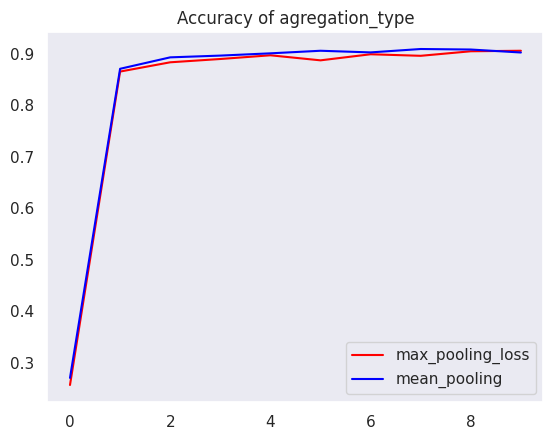

In [18]:
x_max = np.arange(len(base_accuracy['max']))
x_mean = np.arange(len(base_accuracy['mean']))

plt.plot(x_max, base_accuracy['max'], label='max_pooling_loss', color='red')

plt.plot(x_mean, base_accuracy['mean'], label='mean_pooling', color='blue')

plt.grid()

plt.title('Accuracy of agregation_type')
plt.legend()

# Эксперименты

Оставим max pooling, а также попробуем увеличить размер батча и hidden_size и перебрать dropout.

In [25]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

Размер словаря: 11842


In [26]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [32]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 64
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [38]:
num_epochs = 5
eval_step = len(train_dataloader) // 2

some_loss = {}
some_accuracy = {}

for p in [0.1, 0.2, 0.3]:
    print(f"starting training with p: {p}")
    losses = []
    accuracy = []

    model = Baseline(vocab_size=len(vocab), hidden_dim=512, agregation_type='max', num_layers=1, p=p).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epochs):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch : {epoch}')):
            optimizer.zero_grad()

            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            if i % eval_step == 0:
                model.eval()
                accuracy.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))
    some_loss[p] = losses
    some_accuracy[p] = accuracy




starting training with p: 0.1


Training epoch : 0:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 1:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 2:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 3:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 4:   0%|          | 0/1875 [00:00<?, ?it/s]

starting training with p: 0.2


Training epoch : 0:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 1:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 2:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 3:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 4:   0%|          | 0/1875 [00:00<?, ?it/s]

starting training with p: 0.3


Training epoch : 0:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 1:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 2:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 3:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 4:   0%|          | 0/1875 [00:00<?, ?it/s]

In [42]:
[(some_accuracy[key][-1], key)  for key in some_accuracy.keys()]

[(0.9083999991416931, 0.1),
 (0.9081999659538269, 0.2),
 (0.9041999578475952, 0.3)]

точность при 0.1 и 0.2 примерно одиннаковая, посмотрим на loss

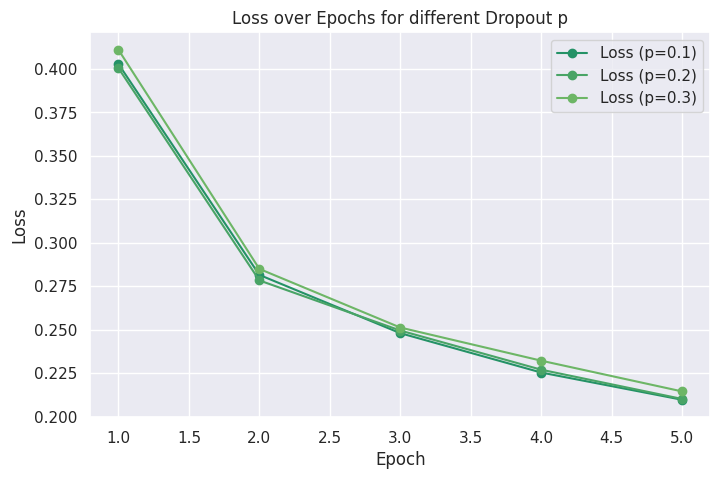

In [41]:
import matplotlib.pyplot as plt

epochs = range(1, len(next(iter(some_loss.values()))) + 1)

plt.figure(figsize=(8, 5))

for p in some_loss:
    plt.plot(epochs, some_loss[p], marker='o', linestyle='-', label=f'Loss (p={p})')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs for different Dropout p')
plt.legend()
plt.grid(True)
plt.show()

Видим что loss чуть лучше при p=0.1, оставим его и попробуем перебрать num_layers

In [43]:
num_epochs = 5
eval_step = len(train_dataloader) // 2

some_loss = {}
some_accuracy = {}

for num_layers in [1, 2, 3]:
    print(f"starting training with num_layers: {num_layers}")
    losses = []
    accuracy = []

    model = Baseline(vocab_size=len(vocab), hidden_dim=512, agregation_type='max', num_layers=num_layers, p=0.1).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epochs):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch : {epoch}')):
            optimizer.zero_grad()

            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            if i % eval_step == 0:
                model.eval()
                accuracy.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))
    some_loss[num_layers] = losses
    some_accuracy[num_layers] = accuracy




starting training with num_layers: 1


Training epoch : 0:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 1:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 2:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 3:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 4:   0%|          | 0/1875 [00:00<?, ?it/s]

starting training with num_layers: 2


Training epoch : 0:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 1:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 2:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 3:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 4:   0%|          | 0/1875 [00:00<?, ?it/s]

starting training with num_layers: 3


Training epoch : 0:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 1:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 2:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 3:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 4:   0%|          | 0/1875 [00:00<?, ?it/s]

In [45]:
[(some_accuracy[key][-1], key)  for key in some_accuracy.keys()]

[(0.9055999517440796, 1), (0.9027999639511108, 2), (0.9093999862670898, 3)]

Видим некое улучшение при num_layers=3, но этого недостаточно

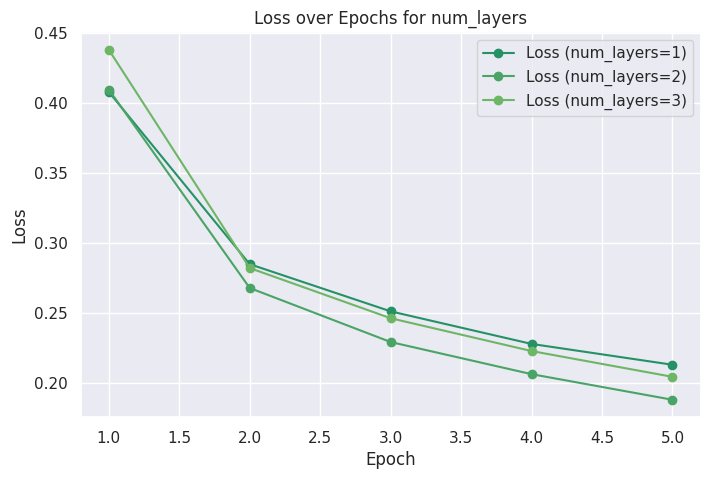

In [46]:
import matplotlib.pyplot as plt

epochs = range(1, len(next(iter(some_loss.values()))) + 1)

plt.figure(figsize=(8, 5))

for num_layers in some_loss:
    plt.plot(epochs, some_loss[num_layers], marker='o', linestyle='-', label=f'Loss (num_layers={num_layers})')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs for num_layers')
plt.legend()
plt.grid(True)
plt.show()

Попробуем GRU

In [47]:
class GRU(nn.Module):
    def __init__(self, hidden_dim, vocab_size, agregation_type, num_layers, p, num_classes : int=4):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.project = nn.Linear(hidden_dim, num_classes)

        self.foa = nn.Tanh()
        self.dropout = nn.Dropout(p=p)
        self.agregation_type = agregation_type

    def forward(self, input_batch):
        embeddings = self.embeddings(input_batch) # [batch_size, seq_len, hidden_size]
        output, _ = self.rnn(embeddings)

        if self.agregation_type == 'max':
            output = output.max(dim=1)[0]

        elif self.agregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError('Invalid agregation type')

        output = self.dropout(self.linear(self.foa(output))) # batch_size, hidden_dim
        predict = self.project(self.foa(output)) # batch_size, num_classes
        return predict


In [48]:
num_epochs = 5
eval_step = len(train_dataloader) // 2

some_loss = {}
some_accuracy = {}

for num_layers in [1, 2, 3]:
    print(f"starting training with num_layers: {num_layers}")
    losses = []
    accuracy = []

    model = GRU(vocab_size=len(vocab), hidden_dim=512, agregation_type='max', num_layers=num_layers, p=0.1).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epochs):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch : {epoch}')):
            optimizer.zero_grad()

            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            if i % eval_step == 0:
                model.eval()
                accuracy.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))
    some_loss[num_layers] = losses
    some_accuracy[num_layers] = accuracy




starting training with num_layers: 1


Training epoch : 0:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 1:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 2:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 3:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 4:   0%|          | 0/1875 [00:00<?, ?it/s]

starting training with num_layers: 2


Training epoch : 0:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 1:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 2:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 3:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 4:   0%|          | 0/1875 [00:00<?, ?it/s]

starting training with num_layers: 3


Training epoch : 0:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 1:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 2:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 3:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 4:   0%|          | 0/1875 [00:00<?, ?it/s]

In [50]:
[(some_accuracy[key][-1], key)  for key in some_accuracy.keys()]

[(0.9115999937057495, 1), (0.9121999740600586, 2), (0.9021999835968018, 3)]

Итак, accuracy повысился, посмотрим на лосс

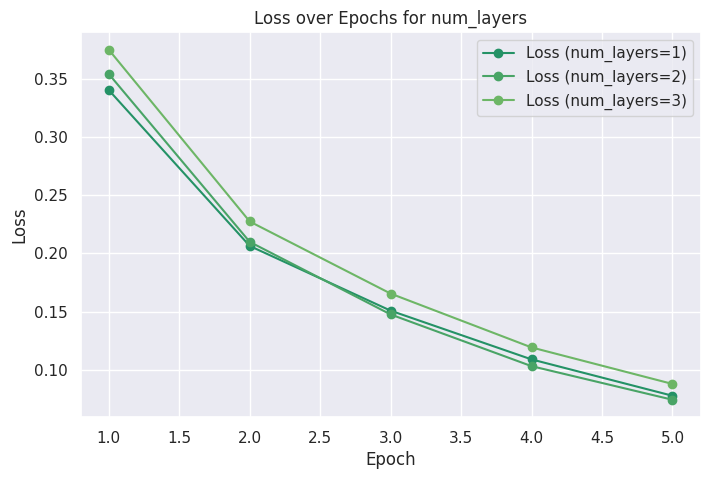

In [51]:
import matplotlib.pyplot as plt

epochs = range(1, len(next(iter(some_loss.values()))) + 1)

plt.figure(figsize=(8, 5))

for num_layers in some_loss:
    plt.plot(epochs, some_loss[num_layers], marker='o', linestyle='-', label=f'Loss (num_layers={num_layers})')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs for num_layers')
plt.legend()
plt.grid(True)
plt.show()

Теперь попробуем lstm

In [52]:
class LSTM(nn.Module):
    def __init__(self, hidden_dim, vocab_size, agregation_type, num_layers, p, num_classes : int=4):
        super().__init__()

        self.embeddings = nn.Embedding(vocab_size, hidden_dim)

        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.project = nn.Linear(hidden_dim, num_classes)

        self.foa = nn.Tanh()
        self.dropout = nn.Dropout(p=p)

        self.agregation_type = agregation_type

    def forward(self, input_batch):
        embeddings = self.embeddings(input_batch)  # [batch_size, seq_len, hidden_size]

        output, _ = self.lstm(embeddings)

        if self.agregation_type == 'max':
            output = output.max(dim=1)[0]
        elif self.agregation_type == 'mean':
            output = output.mean(dim=1)
        else:
            raise ValueError('Invalid agregation type')

        output = self.dropout(self.linear(self.foa(output)))  # batch_size, hidden_dim

        predict = self.project(self.foa(output))  # batch_size, num_classes

        return predict

In [53]:
num_epochs = 5
eval_step = len(train_dataloader) // 2

some_loss = {}
some_accuracy = {}

for num_layers in [1, 2, 3]:
    print(f"starting training with num_layers: {num_layers}")
    losses = []
    accuracy = []

    model = LSTM(vocab_size=len(vocab), hidden_dim=512, agregation_type='max', num_layers=num_layers, p=0.1).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epochs):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch : {epoch}')):
            optimizer.zero_grad()

            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())

            if i % eval_step == 0:
                model.eval()
                accuracy.append(evaluate(model, eval_dataloader))
                model.train()

        losses.append(sum(epoch_losses) / len(epoch_losses))
    some_loss[num_layers] = losses
    some_accuracy[num_layers] = accuracy




starting training with num_layers: 1


Training epoch : 0:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 1:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 2:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 3:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 4:   0%|          | 0/1875 [00:00<?, ?it/s]

starting training with num_layers: 2


Training epoch : 0:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 1:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 2:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 3:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 4:   0%|          | 0/1875 [00:00<?, ?it/s]

starting training with num_layers: 3


Training epoch : 0:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 1:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 2:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 3:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch : 4:   0%|          | 0/1875 [00:00<?, ?it/s]

In [55]:
[(some_accuracy[key][-1], key)  for key in some_accuracy.keys()]

[(0.9063999652862549, 1), (0.9001999497413635, 2), (0.9185999631881714, 3)]

Лучшая accuracy - 0.9186 на 3-х слойной LSTM

# Выводы:

В итоге лучше всего показала себя LSTM(что не удивительно) с hidden_size=512, p=0.1 в dropout и 3 слоями.

В основном все попытки улучшить Vanilla RNN не сильно увенчались успехом, заметные улучшения были только при увелечении количества слоем rnn и hidden size

GRU на тех же гиперпараметрах уже показала себя чуть лучше.

Лидером в итоге осталась LSTM.

Лучший скор: 0.9186. Удалось относительно бейслайна улучшить на ~0.13